In [19]:
import pandas as pd
import numpy as np
import scipy.linalg as sc
from matplotlib import pyplot as plt
from plot import plotstart

raw = pd.read_csv("/Users/nickmisiiuk/dev/PHYS369/data/legac+gz.csv")

low_mag = raw[(raw["ip_mag"] <= 22) & (raw["zp_mag"] <= 22)] #remove high magnitude galaxies and reduce uncertainty

gal_smooth = low_mag[low_mag["type"] == "S"]

gal_feat = low_mag[low_mag["type"] == "F"]

In [ ]:
# Plot log(SFR) vs redshift
plot_data = [[gal_smooth["z_spec"], gal_smooth["lsfr_UV_IR"]],
             [gal_feat["z_spec"], gal_feat["lsfr_UV_IR"]]]

plotstart(plot_data, "scatter", dataset=[
          "Smooth", "Featured"], y_label="log(SFR)", x_label="Redshift")

In [ ]:
# Plot radio sfr vs redshift
plot_data = [[gal_smooth["z_spec"], gal_smooth["sfr_3ghz"]], #errors "esfr_3ghz"
             [gal_feat["z_spec"], gal_feat["sfr_3ghz"]]]

plotstart(plot_data, "scatter", dataset=[
          "Smooth", "Featured"], y_label="sfr_3ghz", x_label="Redshift")

In [20]:
#Import Lega-C dataset and clean it
legac = pd.read_csv("/Users/nickmisiiuk/dev/PHYS369/data/legac.csv")
legac_1 = legac[(legac["ip_mag"] <= 22) & (legac["zp_mag"] <= 22)]

#Filter anomalies
legac_final = legac_1[(legac_1["lsfr_UV"]> -90) & (legac_1["lsfr_IR"]> -90)]
#Filter out the negative values
legac_final = legac_final[legac_final["sfr_3ghz"]> 0]

legac_final["sfr_3ghz"] = legac_final["sfr_3ghz"].apply(np.log)

### ML Approach
Combining SFR data from UV and IR, plotting relation A*uv + B*ir VS radio SFR to determine values of A and B that produce a correlation of 1

In [21]:
#Import required sklearn modules
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Define what are out model variables. We have identified that the best ones are:
x = legac_final[['lsfr_UV', 'lsfr_IR']]
# We want to predict the outcome, in this case either 0 (no claim) or 1 (claim)
y = legac_final['sfr_3ghz']

# splitting the data into a sub-set to train and the rest to test a simple model
# Using 20% of the sample drawn up randomly multiple times to train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# creating an object of LinearRegression class
LR = LinearRegression(fit_intercept=True)
# fitting the training data and providing us with a simple model and how outcome depends linearly on the 5 parameters picked up
LR.fit(x_train,y_train)

coeffs = LR.coef_
print("A", coeffs[0])
print("B", coeffs[1])

# Get the predicted values of sfr
sfr_predicted = LR.predict(x_test)

# predicting the accuracy score
score = r2_score(y_test,sfr_predicted)

print('r^2:',score)
print('mean squared error:',mean_squared_error(y_test,sfr_predicted))
print('root mean squared error:',np.sqrt(mean_squared_error(y_test,sfr_predicted)))

A -0.15869064164882285
B 1.1221350747015133
r^2: 0.17479912405438136
mean_sqrd_error: 1.2327058139950995
root_mean_squared error: 1.1102728556508528


Arguing the validity of using these A and B values 

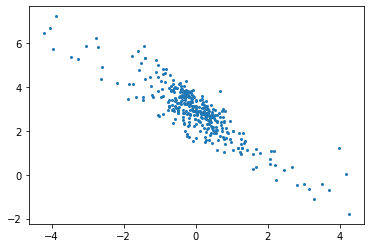

In [36]:
sfr_diff = sfr_predicted - y_test

plt.scatter(sfr_diff, y_test, s=4)
plt.show()

In [ ]:
#Set coefficients A and B
A = -0.15869064
B = 1.12213507

#Create new column of combined UV + IR sfr
low_mag["lSFR_final"] = A * low_mag["lsfr_UV"] + B * low_mag["lsfr_IR"]
low_mag["lSFR_final"] = A * low_mag["lsfr_UV"] + B * low_mag["lsfr_IR"]

#Filter anomalies
new_df = low_mag[(low_mag["lsfr_UV"]> -90) & (low_mag["lsfr_IR"]> -90)]

smooth_df = new_df[new_df["type"] == "S"]
feat_df = new_df[new_df["type"] == "F"]

### Plot of log(SFR) against Redshift for different galaxy morphologies and masses 

In [ ]:
#Split mass into bins
smooth_m1 = smooth_df[smooth_df["fast_lmass"] <= 10.5]
smooth_m2 = smooth_df[(smooth_df["fast_lmass"] >= 10.5) & (smooth_df["fast_lmass"] <= 11)]
smooth_m3 = smooth_df[smooth_df["fast_lmass"] > 11]
feat_m1 = feat_df[feat_df["fast_lmass"] <= 10.5]
feat_m2 = feat_df[(feat_df["fast_lmass"] >= 10.5) & (feat_df["fast_lmass"] <= 11)]
feat_m3 = feat_df[feat_df["fast_lmass"] > 11]

plot_data = [[smooth_m3["z_spec"], smooth_m3["lSFR_final"]], [feat_m3["z_spec"], feat_m3["lSFR_final"]]]

plotstart(plot_data, "scatter", dataset=[
          "Smooth", "Featured"], y_label="lSFR_final", x_label="Redshift")

# Task 2 -- Overdensity

1 -- Basic Plot

In [ ]:
# Filter out anomalic overdensities
legac_overdensity = legac_1[(legac_1["darvish_overdensity"] > -90) & (legac_1["z_spec"] > -90)]

# Plot overdensity vs redshift
plt.figure(dpi=200)
ax = plt.axes()
ax.set_xlabel("Redshift")
ax.set_ylabel("Overdensity")

plt.scatter(legac_overdensity["z_spec"], legac_overdensity["darvish_overdensity"], s=1, marker='.')
plt.tick_params(which='both', direction='in', right=True, top=True)
plt.show()

2 -- **SFR vs Redshift** for different overdensity bins

/var/folders/wn/gh2cl0591kl0782h2mzq82080000gr/T/ipykernel_12979/1686745413.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  legac_overdensity["lSFR_final"] = A * legac_overdensity["lsfr_UV"] + B * legac_overdensity["lsfr_IR"]
/var/folders/wn/gh2cl0591kl0782h2mzq82080000gr/T/ipykernel_12979/1686745413.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  legac_overdensity["lSFR_final"] = A * legac_overdensity["lsfr_UV"] + B * legac_overdensity["lsfr_IR"]


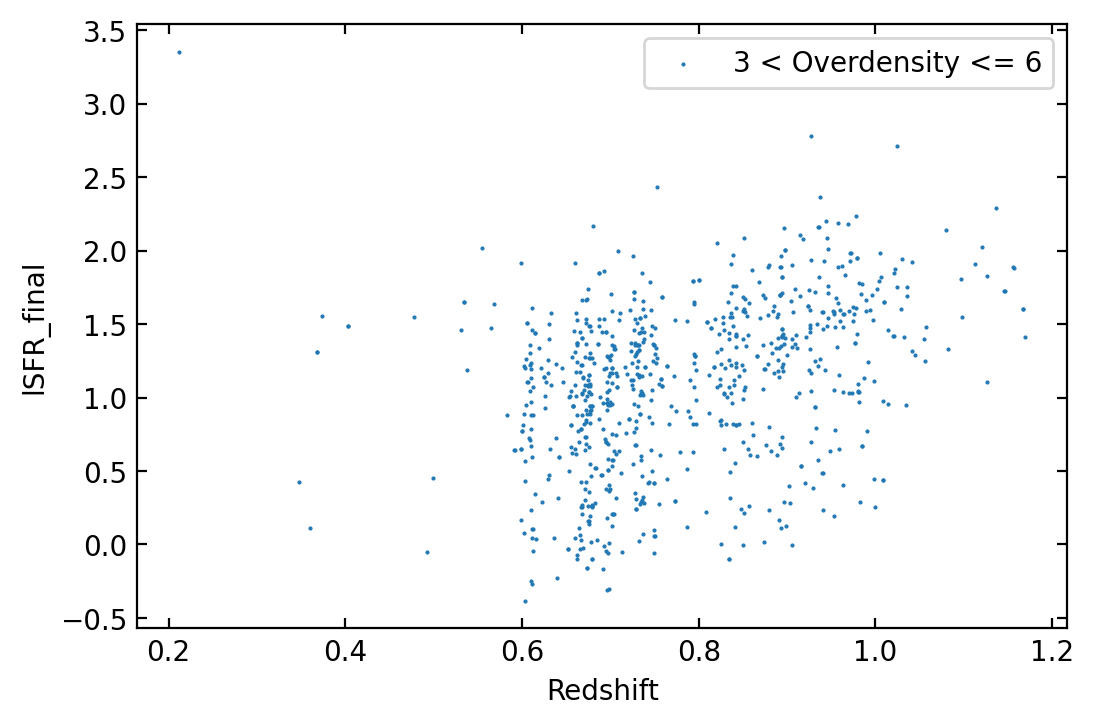

In [17]:
# New SFR column in raw legacy dataset of combined UV + IR sfr
legac_overdensity["lSFR_final"] = A * legac_overdensity["lsfr_UV"] + B * legac_overdensity["lsfr_IR"]
legac_overdensity["lSFR_final"] = A * legac_overdensity["lsfr_UV"] + B * legac_overdensity["lsfr_IR"]

legac_overdensity = legac_overdensity[(legac_overdensity["lSFR_final"] > -20) & (legac_overdensity["lSFR_final"] < 10)]

#Create different overdensity bins
legac_overdensity_1 = legac_overdensity[legac_overdensity["darvish_overdensity"] <= 1]
legac_overdensity_2 = legac_overdensity[(legac_overdensity["darvish_overdensity"] > 1) & (legac_overdensity["darvish_overdensity"] <= 3)]
legac_overdensity_3 = legac_overdensity[(legac_overdensity["darvish_overdensity"] > 3) & (legac_overdensity["darvish_overdensity"] <= 6)]
legac_overdensity_4 = legac_overdensity[(legac_overdensity["darvish_overdensity"] > 6) & (legac_overdensity["darvish_overdensity"] <= 9)]
legac_overdensity_5 = legac_overdensity[legac_overdensity["darvish_overdensity"] > 9]

#Plot SFR vs redshift
plt.figure(dpi=200)
ax = plt.axes()
ax.set_xlabel("Redshift")
ax.set_ylabel("lSFR_final")

plt.scatter(legac_overdensity_2
["z_spec"], legac_overdensity_2
["lSFR_final"], s=1, marker=".", label="3 < Overdensity <= 6")
plt.tick_params(which='both', direction='in', right=True, top=True)
plt.legend()
plt.show()

In [11]:
coeffs = np.corrcoef(legac_overdensity_2["z_spec"], legac_overdensity_2["lSFR_final"])
c = sc.
print(coeffs)

[[1.         0.34408857]
 [0.34408857 1.        ]]
